- Set up [anaconda with python 3.7](https://www.anaconda.com/distribution/#download-section). **If you already have it installed** but you don't want to change the versions of your modules etc, you can make a new conda environment, with: ``conda create --name py37 python=3.7`` then activate it with ``source activate py37``.
    
- Next install [GPFlow](https://github.com/GPflow/GPflow). To do this we install from their development branch which can deal with the new Tensorflow:

        pip install git+https://github.com/GPflow/GPflow.git@develop#egg=gpflow
        
- "This will automatically install all required dependencies. (Note: as of January 2020, PyPI only has tensorflow 2.x for python 3.6 and 3.7, not for python 3.8, which is the latest release and the Anaconda default.)"
- I found that because I had an older version of tensorflow this broke, and I had to install the new version of tensorflow. And also run pip install --upgrade multipledispatch

Then based on the [notebook](https://github.com/GPflow/docs/blob/master/doc/source/notebooks/basics/regression.ipynb) provided by James.

In [30]:
import pandas as pd
from google.cloud import bigquery
from pandas import Timestamp
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
from gpflow import set_trainable
import pickle
%matplotlib inline

# Get Sensor Data

We need to install google-cloud-bigquery:

        pip install google-cloud-bigquery
        
Then using Dennis' code:

In [6]:
#You'll need to ask google cloud platform for your own json file
client = bigquery.Client.from_service_account_json("/home/mike/.gcp_keys/AirQo-519978d8cadc.json")

In [7]:
def get_static_channels():
    sql = """
        SELECT channel_id 
        FROM `airqo-250220.thingspeak.channel` 
        WHERE NOT LOWER(name) LIKE '%mobile%' 
        LIMIT 1000
    """
    channels = [channel.channel_id for channel in client.query(sql).result()]
    return channels

channels = get_static_channels()
channels[0:5]



def get_df(channel_id):
    sql = """
    SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    return df

def get_loc(channel_id):
    sql = """
    SELECT channel_id, longitude, latitude 
    FROM `airqo-250220.thingspeak.channel`
    WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    
    return df
def get_entries_since(channel_id,daysago=7):
    from datetime import datetime,timedelta
    datestring = (datetime.now()-timedelta(daysago)).strftime("%Y-%m-%d %H:%M:%S") # current date and time

    sql = """
    SELECT created_at, channel_id, pm2_5 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    AND created_at > '{}'
    """.format(channel_id,datestring)

    df = client.query(sql).to_dataframe() 
    
    return df

In [41]:
#Run this the first time, to get the data - then later you can just use the local saved version
#but this will go out of date, obvs.

d = get_entries_since(channels[1]) #this takes ages
X = np.zeros([0,3])
Y = np.zeros([0,1])
for chan in channels:
    print(chan)
    d = get_entries_since(chan)
    loc = get_loc(chan)
    Xnew = np.c_[np.repeat(np.array(loc)[:,1:],d.shape[0],0),[n.timestamp()/3600 for n in d['created_at']]]
    Ynew = np.array(d['pm2_5'])
    X = np.r_[X,Xnew]
    Y = np.r_[Y,Ynew]
import pickle
pickle.dump({'X':X,'Y':Y},open('timeandspacedata.p','wb'))

In [11]:
d = pickle.load(open('timeandspacedata.p','rb'))
X = d['X']
Y = d['Y']

In [22]:
Xtraining = np.array(X)
Ytraining = np.array(Y)[:,None]
keep = ~np.isnan(Ytraining[:,0]) #remove nans from data...
Ytraining = Ytraining[keep,:]
Xtraining = Xtraining[keep,:]

This next cell removes 99.5% of data to make 'standard' GP inference tractable.
You'll remember from the textbook that the time complexity of a GP depends largely on the matrix inversion, which takes $O(N^3)$. To avoid this we'll later need more advanced approximation approaches, but here we use a rather blunt solution which is simply to remove most of the data.

We are sort of doing a sparse approximation here, but just deleting data isn't a very efficient way of doing it.

In [23]:
Xtraining = Xtraining[::200,:]
Ytraining = Ytraining[::200,:]

Define the kernel - a RBF (EQ) kernel with three dimensions, these have different lengthscales.
so the first two are latitude and longitude. These we fix as having a lengthscale = 0.05 (which is
110km * 0.05 = 5.5km, massive. Oh well. The time dimension we assign a lengthscale of 5 hours.

In [64]:
#k = gpflow.kernels.RBF(lengthscales=[0.05, 0.05, 5.]) + gpflow.kernels.Bias()
k = gpflow.kernels.RBF(lengthscales=[0.02, 0.02, 5.]) + gpflow.kernels.Bias()

In [65]:
k

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.02 0.02 5. ]
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0


Here we make the model,
- A simple GP regression (GPR) model.
- 

In [31]:
m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
#Here we tell the optimiser not to alter the lengthscales: thanks Pablo!!!! YAY
set_trainable(m.kernel.kernels[0].lengthscales, False) 

#This just does the gradient ascent to optimise the marginal likelihood of the model (see page 112 of Rassmussen & Williams)
opt = gpflow.optimizers.Scipy()
def objective_closure():
    return - m.log_marginal_likelihood()
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))

In [33]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,653.9185441452297
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,False,"(3,)",float64,[0.05 0.05 5. ]
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,839.4320854509085
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,871.0891570131852


In [40]:
np.var(Ytraining)

1375.2294624186995

Is our data really normal, conditioned on the location & time?

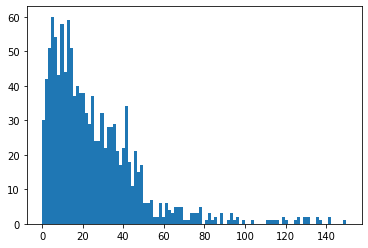

In [44]:
plt.hist(Ytraining,np.linspace(0,150,100));

(0, 100)

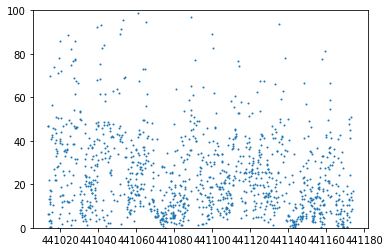

In [45]:
plt.scatter(Xtraining[:,2],Ytraining,1)
plt.ylim([0,100])

Here I just get the middle of the locations and time, so I can make an appropriate test grid that lies on top of all the data.

In [47]:
np.median(Xtraining,0)

array([3.26000000e+01, 3.41674000e-01, 4.41093493e+05])

Here we make a 2d grid over space centred roughly on the middle of the data.

In [51]:
Xtest = np.meshgrid(np.linspace(32.4,32.8,150),np.linspace(0.1,0.5,150))

Here we loop over 14 time points.

Note: The time is in hours since epoch. We can use:

        Timestamp.fromtimestamp(time*3600)
        
to get back to the time we understand:

In [52]:
Timestamp.fromtimestamp(np.median(Xtraining,0)[2]*3600)

Timestamp('2020-04-26 22:29:34')

The above is the median time in the data.

Below we plot predictions over space for different times.
The left hand set of plots are the predictions themselves (the latent posterior mean)
The right hand plots are for the standard deviation in the latent posterior.
So a smaller number in the right hand one means the model is more confident.

It's basically the error bars - but I can't easily draw errorbars in a 2d plot.

Also - see previous plots we looked at, and Dennis' new ones where we use dot-size to indicate precision, which is inverse variance?

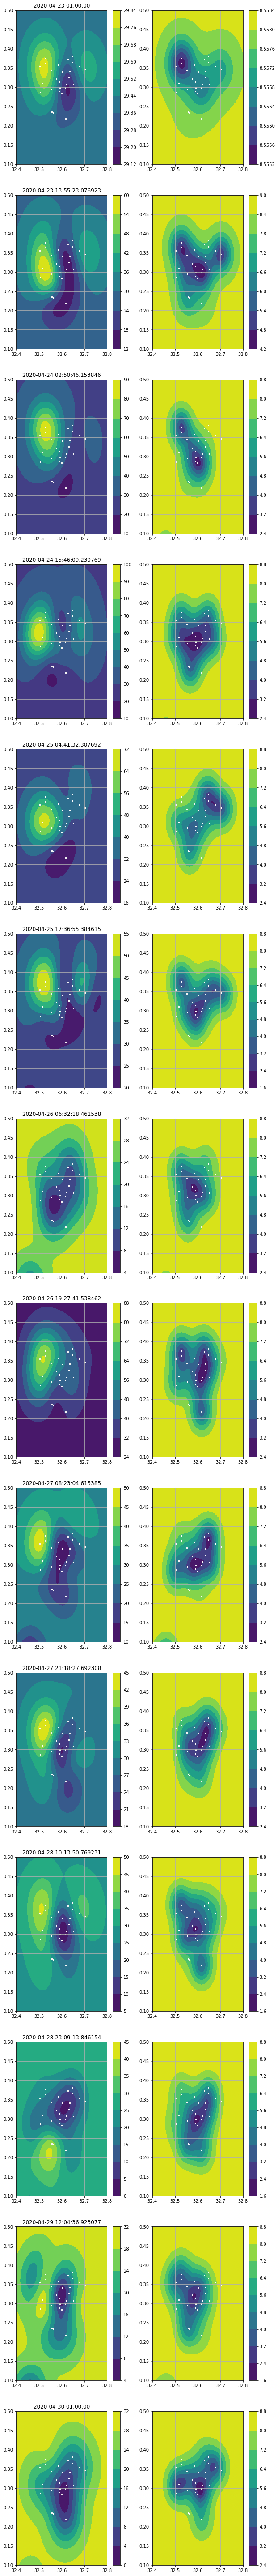

In [63]:
plt.figure(figsize=[10,105])
i=0
for predtime in np.linspace(4.41e5+0,4.41e5+7*24,14):
    #need to build a X test matrix, this has a column for lat, long and time, and each row is a test point...
    Xtestflat = np.c_[Xtest[0].flatten(),Xtest[1].flatten()]
    #here we're adding the predtime (the time we want to predict for)
    Xtestflat = np.c_[Xtestflat,np.full(Xtestflat.shape[0],predtime)]
    
    #here we ask for the mean and variance of the LATENT posterior prediction. "_f" is the bit that means we want
    #the posterior variance. The mean of the latent posterior will be the same as over the observations (as we're
    #using a symmetric likelihood).
    #the variance will be less for the latent posterior obviously.
    
    
    #Homework: try predict_f and predict_y, what changes, what does it mean?
    predmeans,predvars = m.predict_f(Xtestflat)
    i+=1
    plt.subplot(14,2,i)
    plt.xlim([32.4,32.8])
    plt.ylim([0.1,0.5])
    plt.contourf(Xtest[0],Xtest[1],predmeans.numpy().reshape([150,150]))
    #plt.clim([0,150])
    plt.colorbar()
    plt.scatter(Xtraining[:,0],Xtraining[:,1],1,color='w')
    plt.title(Timestamp.fromtimestamp(predtime*3600))
    plt.grid()
    
    i+=1
    plt.subplot(14,2,i)
    plt.xlim([32.4,32.8])
    plt.ylim([0.1,0.5])
    plt.contourf(Xtest[0],Xtest[1],np.sqrt(predvars.numpy()).reshape([150,150]))
    #plt.clim([0,27])
    plt.colorbar()
    plt.scatter(Xtraining[:,0],Xtraining[:,1],1,color='w')
    plt.grid()

At 2020-04-23 01:00:00: The model had no idea.. look at the numbers on the right hand-side, the standard deviation is ~25, so our model is saying the pollution is rougly between -23 and +73 for all locations - it doesn't know.

As we move through time we get more confident as there's more data to support the prediction.

In the middle of town we are also more confident for the same reason. The uncertainty is still quite large. The posterior standard deviation is at least 10 ug/m^3 so all our predictions for the latent pollution are +/- 20 ug/m^3 AND the posterior with the 'noise' is probably a more appropriate output, which has even more uncertainty.

Our data is quite thin, that might make the uncertainty worse. We also have quite a limited model - we don't know about roads etc.



# Approximations

They can be split into numerical or analytic. Numerical include MCMC etc... analyic include VI and sparse approximations and also the basis approximations that Pablo is working on.

## Sparse Approximations

- "Historic"/skip?: http://papers.nips.cc/paper/2857-sparse-gaussian-processes-using-pseudo-inputs.pdf
- Unifying/review: http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf
- Variational Inference: http://www.jmlr.org/proceedings/papers/v5/titsias09a/titsias09a.pdf
    - Can treat the locations as parameters of the ELBO.
- Stochastic Variational Inference: https://arxiv.org/pdf/1309.6835

gpflow probabably uses one of the last two references.

These all require inducing points to be placed. Typically one might initialise them with k-means clustering or something simple. In the code below though I just stick them at the locations of 1/1000th of the data.

`SGPR` = Sparse Gaussian process regression

In [60]:
Xtraining = np.array(X)
Ytraining = np.array(Y)[:,None]
keep = ~np.isnan(Ytraining[:,0]) #remove nans from data...
Ytraining = Ytraining[keep,:]
Xtraining = Xtraining[keep,:]

In [62]:
k = gpflow.kernels.RBF(lengthscales=[0.05, 0.05, 5.]) + gpflow.kernels.Bias()

#here we define our model!
#
m = gpflow.models.SGPR(data=(Xtraining[::10,:], Ytraining[::10,:]),
                       kernel=k, mean_function=None,inducing_variable=Xtraining[::1000,:])
from gpflow import set_trainable
set_trainable(m.kernel.kernels[0].lengthscales, False)
set_trainable(m.inducing_variable.Z, False) #One thing - I found this really slow to optimise.

opt = gpflow.optimizers.Scipy()
def objective_closure():
    print(m.log_marginal_likelihood())
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))


Tensor("add_17:0", shape=(), dtype=float64)


KeyboardInterrupt: 